# Credit Card Fraud Detection
by Stuart Miller

[Github Profile](https://github.com/sjmiller8182)

## Introduction

This dataset is from Machine Learning Gorup - ULB and is hosted by Kaggle [here](https://www.kaggle.com/mlg-ulb/creditcardfraud).

This dataset was generated from real transactions from European card holders. Due to confidentiality the original data set was not provided. The set contains columns labeled time, class, amount and V1 - V28. The columns V1 - V28 are the priciple components of the original data set. Class is 0 for normal transactions and 1 for fraudulant transactions. Time is the time between the first transaction and the current transaction in seconds. Amount is the transaction amount.

**Analysis question**: Is it possible to detect fraudulant transactions?

## Data Exploration

First a look at the data structure and the data characteristics.

In [106]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

Read in data and print head to verify data loaded correctly.

In [2]:
# read in data
data = pd.read_csv('../../data/creditcardfraud/creditcard.csv')
data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

### Make type coversions

**Class** is the variable for distingushing transactions as fraud or normal. This should be a category variable. It will also be converted to fraud/normal rather than 1/0 for indicators.

**Time** is measured in seconds as the time the transaction occured with reference to the first transaction in the table. **Del_Time** will be converted to the time between each transaction and the type converted to time delta (Pandas type).

In [3]:
data['Class'] = data.Class.replace({0:'Normal',1:'Fraud'}).astype('category')

new_col = data.Time[1:].reset_index(drop = True) - data.Time[0:-1]
new_col = np.hstack(([0], new_col.values))
data['Del_Time'] = pd.to_timedelta(new_col, unit='s')
data.Time = data.Time.astype('datetime64[ns]')

In [4]:
data.head()

Time        V1        V2        V3        V4  \
0 1970-01-01 00:00:00.000000000 -1.359807 -0.072781  2.536347  1.378155   
1 1970-01-01 00:00:00.000000000  1.191857  0.266151  0.166480  0.448154   
2 1970-01-01 00:00:00.000000001 -1.358354 -1.340163  1.773209  0.379780   
3 1970-01-01 00:00:00.000000001 -0.966272 -0.185226  1.792993 -0.863291   
4 1970-01-01 00:00:00.000000002 -1.158233  0.877737  1.548718  0.403034   

         V5        V6        V7        V8        V9  ...       V22       V23  \
0 -0.338321  0.462388  0.239599  0.098698  0.363787  ...  0.277838 -0.110474   
1  0.060018 -0.082361 -0.078803  0.085102 -0.255425  ... -0.638672  0.101288   
2 -0.503198  1.800499  0.791461  0.247676 -1.514654  ...  0.771679  0.909412   
3 -0.010309  1.247203  0.237609  0.377436 -1.387024  ...  0.005274 -0.190321   
4 -0.407193  0.095921  0.592941 -0.270533  0.817739  ...  0.798278 -0.137458   

        V24       V25       V26       V27       V28  Amount   Class  Del_Time  
0  0.066928  0.128539 -0.189115  0.133558 -0.021053  149.62  Normal  00:00:00  
1 -0.339846  0.167170  0.125895 -0.008983  0.014724    2.69  Normal  00:00:00  
2 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752  378.66  Normal  00:00:01  
3 -1.175575  0.647376 -0.221929  0.062723  0.061458  123.50  Normal  00:00:00  
4  0.141267 -0.206010  0.502292  0.219422  0.215153   69.99  Normal  00:00:01  

[5 rows x 32 columns]

### Get basic info on data
* types
* data set size
* statistical summary
* balance of the classes

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 32 columns):
Time        284807 non-null datetime64[ns]
V1          284807 non-null float64
V2          284807 non-null float64
V3          284807 non-null float64
V4          284807 non-null float64
V5          284807 non-null float64
V6          284807 non-null float64
V7          284807 non-null float64
V8          284807 non-null float64
V9          284807 non-null float64
V10         284807 non-null float64
V11         284807 non-null float64
V12         284807 non-null float64
V13         284807 non-null float64
V14         284807 non-null float64
V15         284807 non-null float64
V16         284807 non-null float64
V17         284807 non-null float64
V18         284807 non-null float64
V19         284807 non-null float64
V20         284807 non-null float64
V21         284807 non-null float64
V22         284807 non-null float64
V23         284807 non-null float64
V24         284807

All features have 284807 observations.

In [6]:
data.describe()

V1            V2            V3            V4            V5  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   3.919560e-15  5.688174e-16 -8.769071e-15  2.782312e-15 -1.552563e-15   
std    1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00  1.380247e+00   
min   -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00 -1.137433e+02   
25%   -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01 -6.915971e-01   
50%    1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02 -5.433583e-02   
75%    1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01  6.119264e-01   
max    2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01  3.480167e+01   

                 V6            V7            V8            V9           V10  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   2.010663e-15 -1.694249e-15 -1.927028e-16 -3.137024e-15  1.768627e-15   
std    1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00  1.088850e+00   
min   -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01 -2.458826e+01   
25%   -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01 -5.354257e-01   
50%   -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02 -9.291738e-02   
75%    3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01  4.539234e-01   
max    7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01  2.374514e+01   

       ...           V21           V22           V23           V24  \
count  ...  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   ...  1.537294e-16  7.959909e-16  5.367590e-16  4.458112e-15   
std    ...  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min    ... -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%    ... -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%    ... -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    ...  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    ...  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                V25           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   1.453003e-15  1.699104e-15 -3.660161e-16 -1.206049e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02       5.600000   
50%    1.659350e-02 -5.213911e-02  1.342146e-03  1.124383e-02      22.000000   
75%    3.507156e-01  2.409522e-01  9.104512e-02  7.827995e-02      77.165000   
max    7.519589e+00  3.517346e+00  3.161220e+01  3.384781e+01   25691.160000   

                     Del_Time  
count                  284807  
mean   0 days 00:00:00.606698  
std    0 days 00:00:01.053379  
min           0 days 00:00:00  
25%           0 days 00:00:00  
50%           0 days 00:00:00  
75%           0 days 00:00:01  
max           0 days 00:00:32  

[8 rows x 30 columns]

In [7]:
# since all columns are full count on any feature - V1

total_transactions = data.V1.count()
num_fraud_transactions = data[data['Class']=='Fraud'].V1.count()
num_real_transactions = data[data['Class']=='Normal'].V1.count()
print("The number of real transactions is {} and the number of fraud transactions is {}." \
      .format(num_real_transactions, num_fraud_transactions))
print("The real transactions account for {:0.4f}% of the total." \
      .format(num_real_transactions/total_transactions*100))
print("The fraud transactions account for {:0.4f}% of the total." \
      .format(num_fraud_transactions/total_transactions*100))

The number of real transactions is 284315 and the number of fraud transactions is 492.
The real transactions account for 99.8273% of the total.
The fraud transactions account for 0.1727% of the total.


The data is **highly unbalanced** with real (legitimate) transactions accounting for more than 99% of the total transactions in the data set.

### Data Exploration
####  Are there correlations between the features of the dataset?

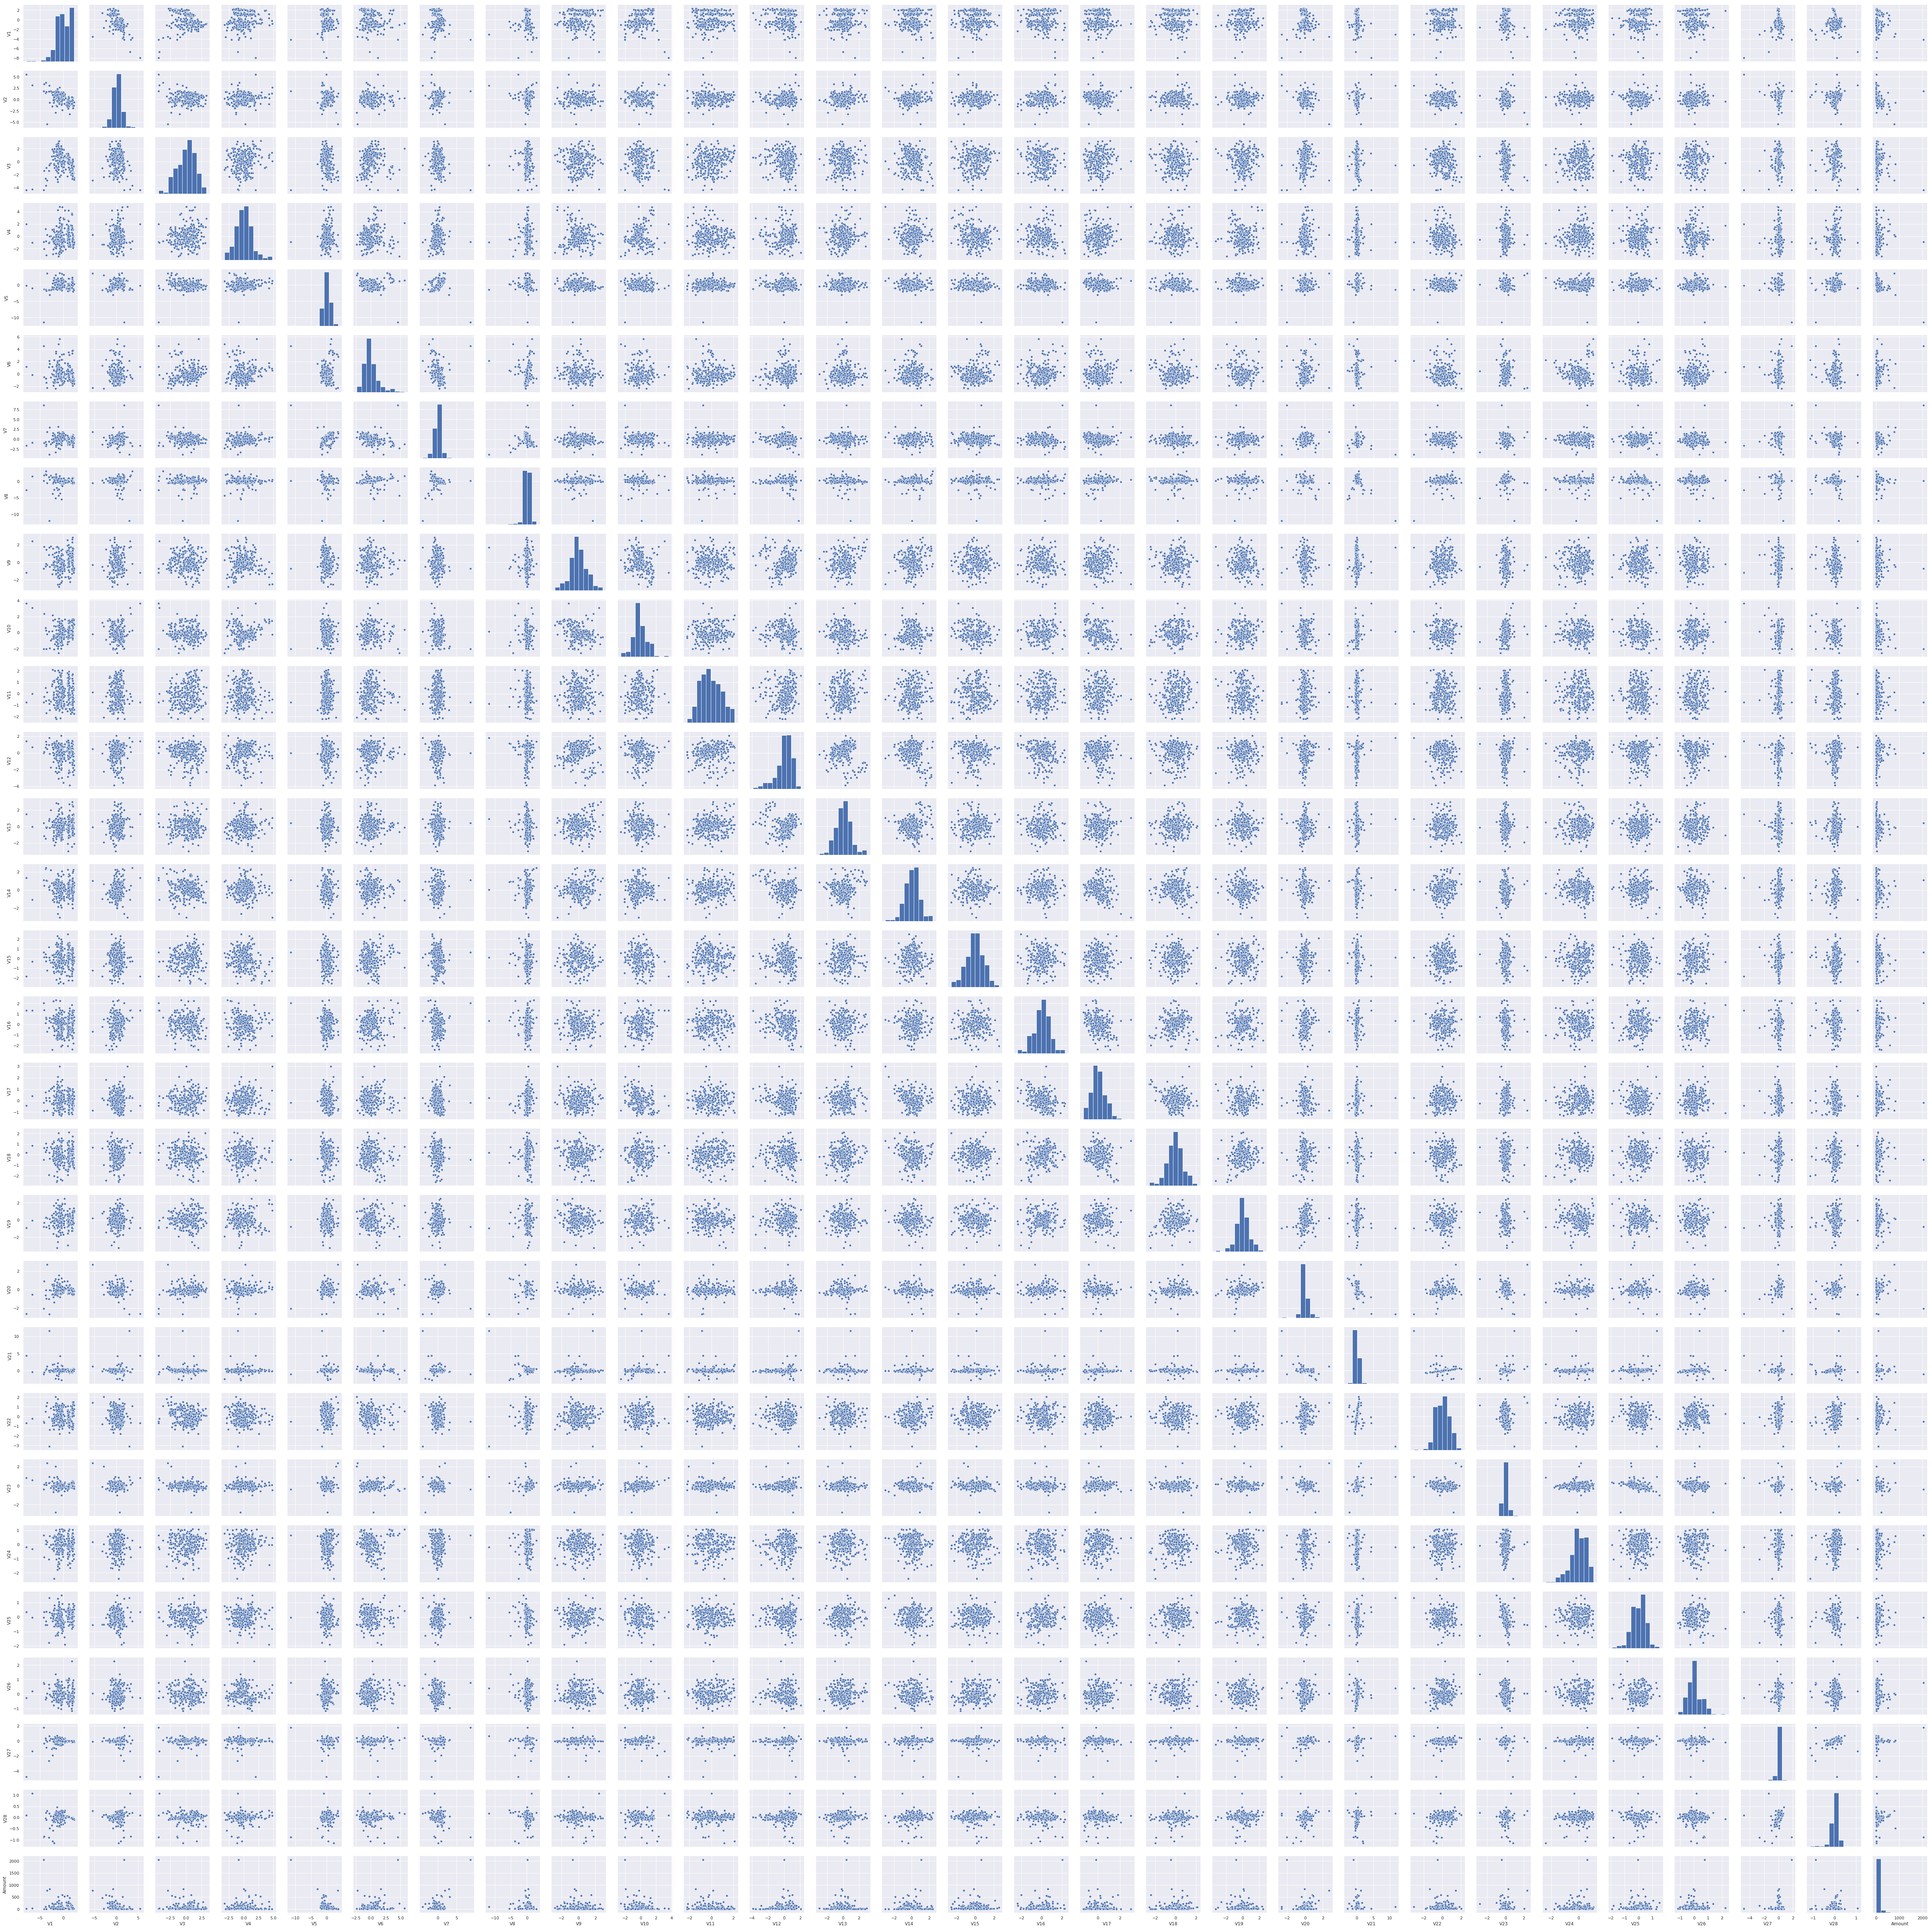

In [8]:
sns.set()
sns.pairplot(data.sample(frac=.001));
# downsample the data to get a reasonable run time

In [8]:
# calc the correlation coefficients between columns
coef = data.corr()
coef[coef > 0.5].count()

V1        1
V2        1
V3        1
V4        1
V5        1
V6        1
V7        1
V8        1
V9        1
V10       1
V11       1
V12       1
V13       1
V14       1
V15       1
V16       1
V17       1
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
dtype: int64

Because there are so many features, it is hard to tell from the pairplot, but it does not look like there are any correlated features. This is backed up by the pearson correlation calculation. There are **no correlations between columns** greater than 0.5. The count '1' that is listed is from the column correlated on itself. *This is not surprising since the description notes that the columns V1-V28 are **principle components**.*

#### Distribution of time and amounts

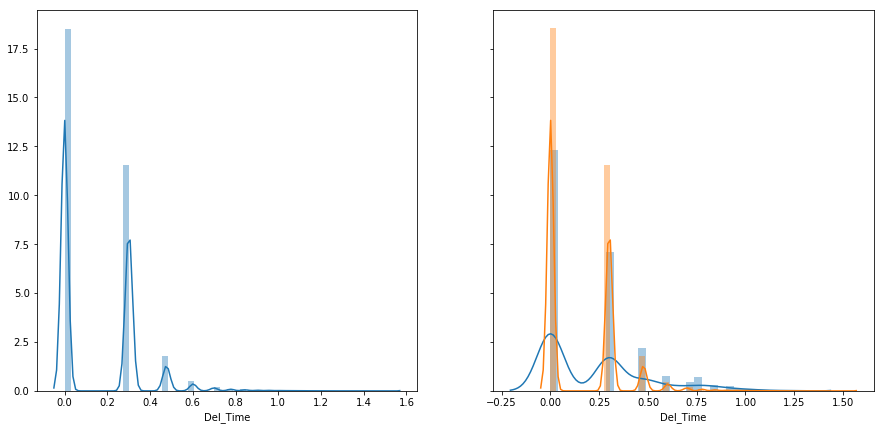

In [9]:
fig, ax = f, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (15,7), sharey=True)
sns.distplot(np.log10(data.Del_Time.dt.total_seconds()+1), ax = ax1);
sns.distplot(np.log10(data.Del_Time[data['Class']=='Fraud'].dt.total_seconds()+1),
             ax = ax2, label = 'Fraud', bins  = 30);
sns.distplot(np.log10(data.Del_Time[data['Class']=='Normal'].dt.total_seconds()+1),
             ax = ax2, label = 'Normal');

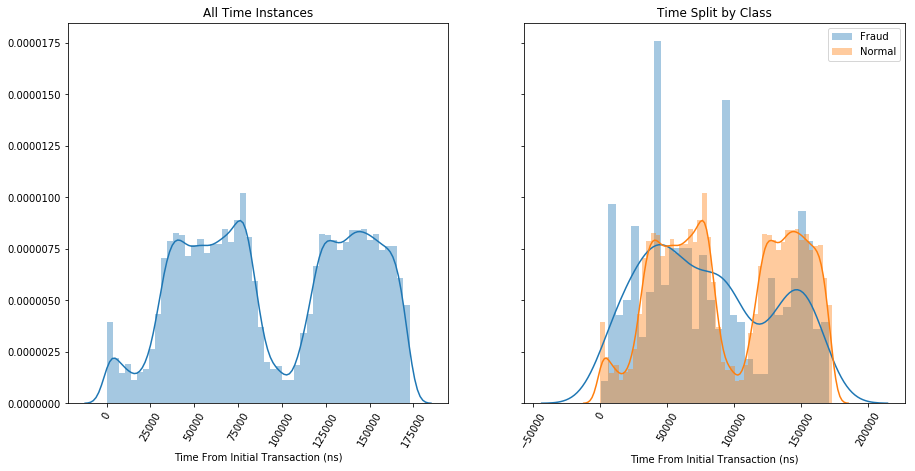

In [10]:
fig, ax = f, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (15,7), sharey=True)

sns.distplot(data.Time.dt.microsecond.values*1000 + data.Time.dt.nanosecond.values, ax = ax1)
sns.distplot(data[data['Class']=='Fraud'].Time.dt.microsecond.values*1000 + 
             data[data['Class']=='Fraud'].Time.dt.nanosecond.values, ax = ax2, bins = 30, label = 'Fraud')
sns.distplot(data[data['Class']=='Normal'].Time.dt.microsecond.values*1000 + 
             data[data['Class']=='Normal'].Time.dt.nanosecond.values, ax = ax2, label = 'Normal')
ax1.set_title('All Time Instances')
ax2.set_title('Time Split by Class')
ax2.legend()
for ax in [ax1,ax2]:
    for item in ax.get_xticklabels():
        item.set_rotation(60)
    ax.set_xlabel('Time From Initial Transaction (ns)');

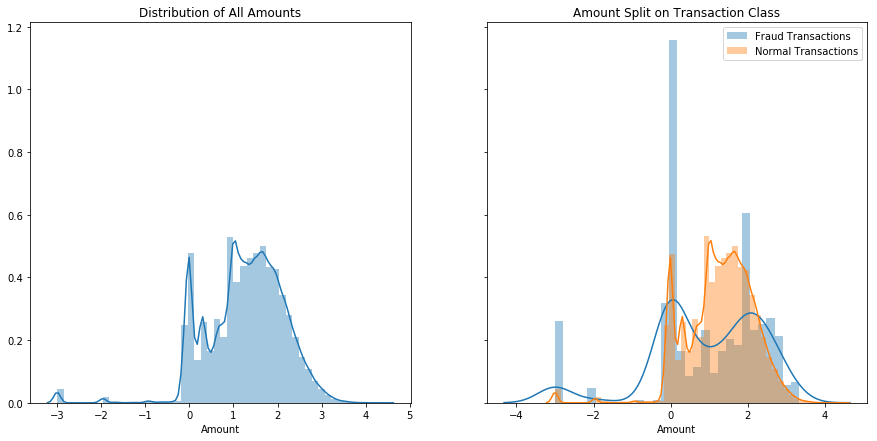

In [11]:
# plot by log10 transform to 'spread out' data
# use amount + .001 to prevent errors from np.log10
fig, ax = f, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (15,7), sharey=True)

sns.distplot(np.log10(.001+data.Amount), ax = ax1);
ax1.set_title('Distribution of All Amounts')

sns.distplot(np.log10(.001+data[data['Class'] == 'Fraud'].Amount), ax = ax2,
             bins = 30, label = 'Fraud Transactions');
sns.distplot(np.log10(.001+data[data['Class'] == 'Normal'].Amount), ax = ax2,
             label = 'Normal Transactions');
ax2.set_title('Amount Split on Transaction Class')
ax2.legend();

There does not seem to be much of a difference between 'Normal' transactions and 'Fraud' transactions with respect to occurance in time. Additionally, transaction amount does not seem to be a distingushing factor.

#### Which features appear to be different between the two classes?

Plot all the 'V' columns split by 'Class' to get a sense of which columns more most dissimilar between 'Class'.

In [12]:
fraud_data = data[data['Class'] == 'Fraud']
normal_data = data[data['Class'] == 'Normal'].sample(frac = 0.005)

In [13]:
resam_data = pd.concat([fraud_data,normal_data])

/home/stuart/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


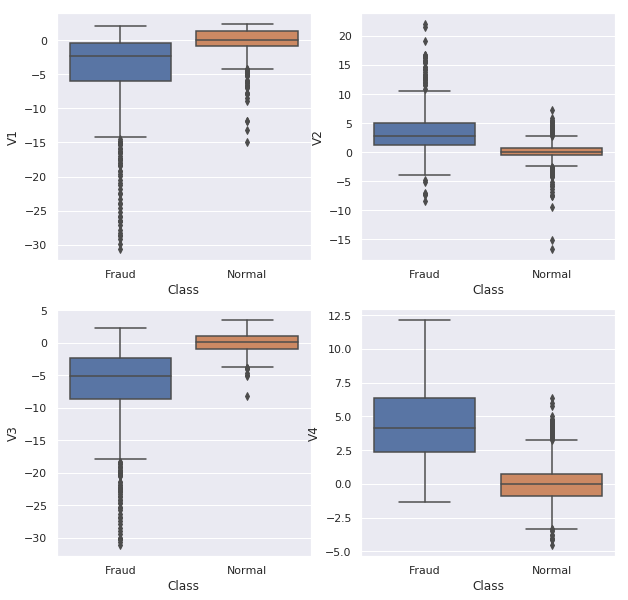

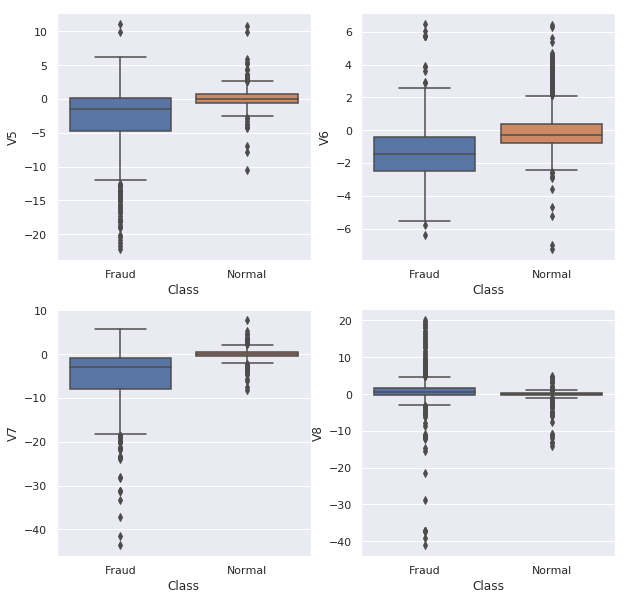

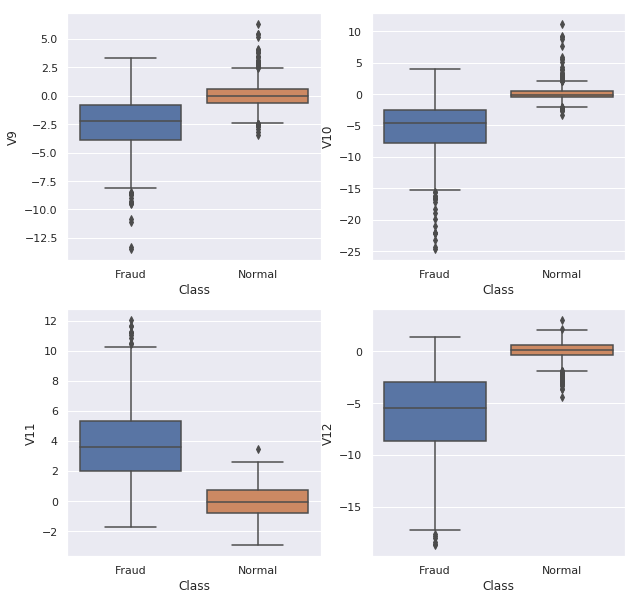

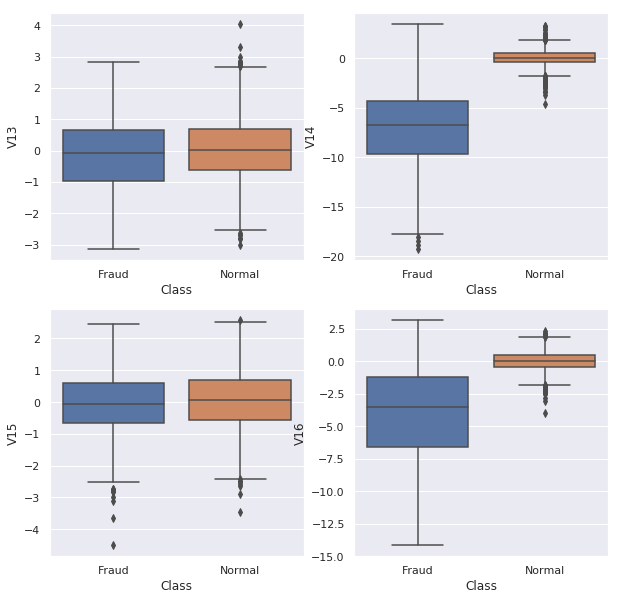

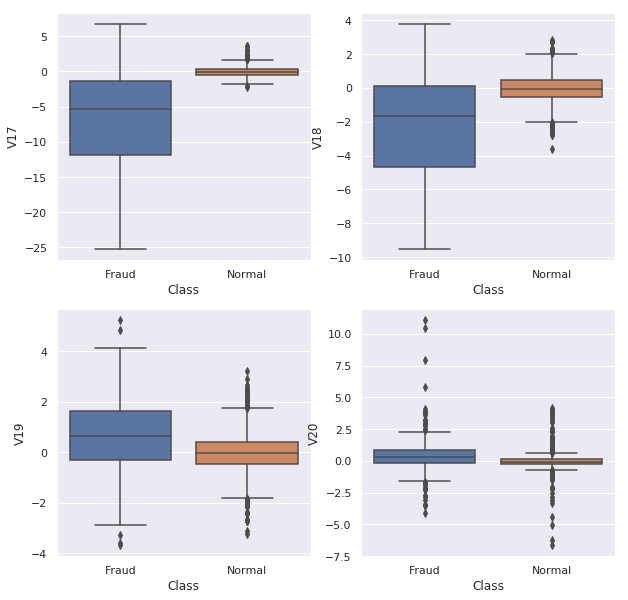

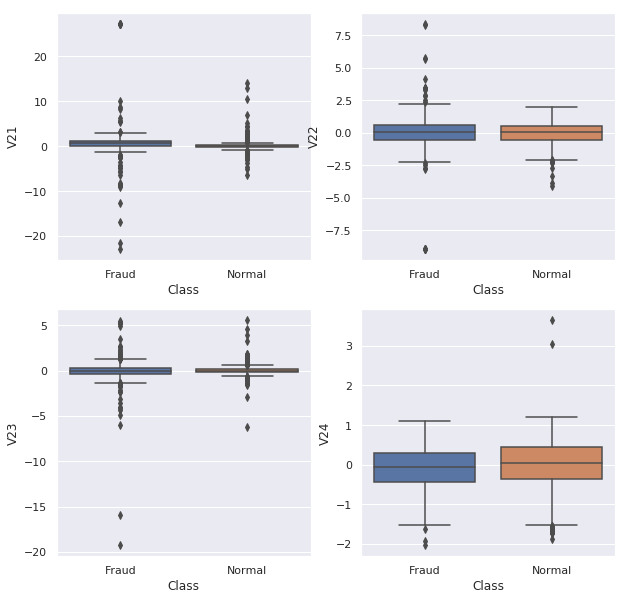

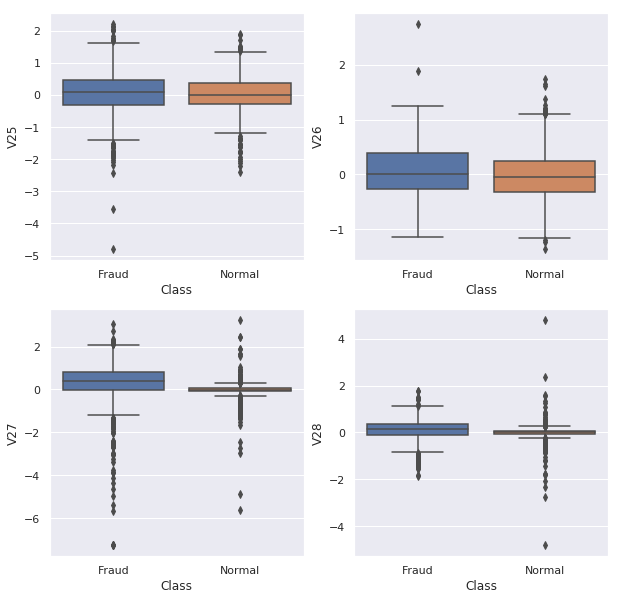

In [14]:
sns.set()
for i in range(0, 7):
    columns = resam_data.columns[1+i*4:i*4+5].values
    fig = plt.figure(figsize=(10, 10))
    for col, plot in zip(columns,range(1,len(columns)+1)):
        sub_plot = fig.add_subplot(2,2,plot)
        sns.catplot(x = 'Class', y = col, kind = 'box',
                    data = resam_data, ax = sub_plot);
        
for i in [2,3,4,5,7,8,9,10,12,13,14,15,17,18,19,20,22,
          23,24,25,27,28,29,30,32,33,34,35]:
    plt.close(i)

From the plots above, the following features of the dataset seem to be best bets on distinguishing the classes using the features: 1,2,3,4,5,7,9,10,11,12,14,16,17,18. A random forest will be used later to estimate feature importances as part of the modeling work flow.

## Detection

### Scoring Premise

In the situation, classifying a fraudulate transaction as legimiate is more damaging than classifiying real transaction as legimiate. If a legimiate transaction is misclassified as fraud, the bank can push a notification, send a text message, call, or send an email to the affected user(s) in real time to request verification. If the opposite case, the user must find and report the transaction, leading to an investigation to verify the report. This is a cost to the institution and the user. So it will be more important to prioritize scoring on misclassifying fraudulant transactions as legimiate transactions.

### Modeling 

Since normal transactions account for the majority of the transaction, just presenting the data to a model may cause the model to train out the fraud on accuracy. Normal data will be down sampled for model training.

* Benchmark with untuned logistic regression model
* Develop scoring mechanism
* Select features with a random forest (or similar)
* Remodel with selected features
* Tune model
* Test model

### Data Preperation

Split out data into testing and training data sets. Use 0.25% of data for testing - split as equal proportions of "normal" and "fraud." 

In [15]:
# pull out a numeric representation of class where Fraud is set to 1
y_total = pd.DataFrame(pd.get_dummies(data.Class).Fraud.to_frame(name = 'Class'))
y_total.head()

Class
0      0
1      0
2      0
3      0
4      0

In [16]:
def restore_as_df(df, drop_cols = ['Del_Time', 'Time', 'Class']):
    '''restore X portion of data as dataframe without "drop columns"'''
    new_cols = list(data.columns.values)
    for i in drop_cols:
        new_cols.remove(i)
    return pd.DataFrame(df, columns = new_cols)

In [17]:
drop_cols = ['Del_Time', 'Time', 'Class']

scaler = MinMaxScaler()

# seperate data on classes before splitting
y_fraud = y_total[y_total['Class']==1]
y_normal = y_total[y_total['Class']==0]

X_fraud = scaler.fit_transform(data[data['Class']=='Fraud'].drop(drop_cols, axis = 1))
X_normal = scaler.fit_transform(data[data['Class']=='Normal'].drop(drop_cols, axis = 1))


X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_fraud,
                                                            y_fraud,
                                                            test_size=0.25, random_state=42)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_normal,
                                                            y_normal,
                                                            test_size=0.25, random_state=42)

In [18]:
f_total = restore_as_df(X_train_f)
n_total = restore_as_df(X_train_n)
f_total['target'] = y_train_f.reset_index(drop = True)
n_total['target'] = y_train_n.reset_index(drop = True)

### Initial Checkout

Checkout an initial logistic regression model for baselining. Check against a different sample of normal data.

* Pull out a validation set as 25% of the training set.
* Down sample the random data by selecting a random sample of normal data that is twice the size of the fraud data.
* Benchmark the logistic regression model on the validation set.

In [53]:
# get validation data
n_val = n_total.sample(frac = 0.25, random_state = 42)
f_val = f_total.sample(frac = 0.25, random_state = 42)

# drop the validation data out of the training data
n_t = n_total.drop(index = n_val.index.values)
f_t = f_total.drop(index = f_val.index.values)


#sample out some training data
nom_to_fraud_ratio = 2 # sampleing ratio
down_sam_n = n_t.sample(n = len(f_total)*nom_to_fraud_ratio, random_state = 50)
X = pd.concat([down_sam_n.drop(columns = 'target'),f_t.drop(columns='target')])
y = pd.concat([down_sam_n['target'],f_t['target']])

In [54]:
# set solver to supress warning
lr = LogisticRegression(solver = 'lbfgs', random_state = 42)
lr.fit(X.values, y.values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [48]:
X = pd.concat([n_val.drop(columns = 'target'),f_val.drop(columns='target')])
y = pd.concat([n_val['target'],f_val['target']])

y_hat = lr.predict(X)

#### Scoring

Primary scoring will be based on the misclassification of fraudulant transactions.

In [66]:
def fraud_classification_rate(y, y_pred, weights = None):
    '''Calculate the number of times fraud is misclassified as a legimiate transaction.'''
    conf = confusion_matrix(y,y_pred)
    return conf[1][1]/(conf[1][1] + conf[1][0])

In [65]:
# get scoring
fraud_classification_rate(y,y_hat)

1.0

In [52]:
# print confusion matrix as a dataframe
pd.crosstab(y, y_hat, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted      0   1    All
True                       
0          53304   5  53309
1              0  92     92
All        53304  97  53401

#### Baselining

Initial model scole fairly classifying all 92 fraudulant transactions in a total of 53401 transactions. Additionally, only 5 of the ~53k legimiate transactions were misclassified (~0.009%). 

#### Feature Selection

It is possible that there are features that do not add mush value to the model. A random forest classifier will be used to rate the importance of features.

In [97]:
#sample out some training data
nom_to_fraud_ratio = 2 # sampleing ratio
down_sam_n = n_t.sample(n = len(f_total)*nom_to_fraud_ratio, random_state = 50)
X = pd.concat([down_sam_n.drop(columns = 'target'),f_t.drop(columns='target')])
y = pd.concat([down_sam_n['target'],f_t['target']])

rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
rf.fit(X.values, y.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [99]:
X = pd.concat([n_val.drop(columns = 'target'),f_val.drop(columns='target')])
y = pd.concat([n_val['target'],f_val['target']])

y_hat = rf.predict(X)

In [101]:
# get scoring
print(fraud_classification_rate(y,y_hat))

# print confusion matrix as a dataframe
pd.crosstab(y, y_hat, rownames=['True'], colnames=['Predicted'], margins=True)

1.0


Predicted      0    1    All
True                        
0          53298   11  53309
1              0   92     92
All        53298  103  53401

In [92]:
importances = pd.DataFrame(data = {'feature':n_total.drop('target', axis = 1).columns,
                                   'importances':rf.feature_importances_}).sort_values(by = 'importances',
                                                                                       ascending = False)

In [94]:
reduced_feat = importances[importances.importances > 0.000001].feature

The random forest classifier selected the following features

In [96]:
reduced_feat

6      V7
19    V20
20    V21
22    V23
4      V5
7      V8
0      V1
9     V10
1      V2
14    V15
5      V6
26    V27
8      V9
16    V17
Name: feature, dtype: object

Retrain the logistic regression model with the reduced feature set.

In [103]:
#sample out some training data
nom_to_fraud_ratio = 2 # sampleing ratio
down_sam_n = n_t.sample(n = len(f_total)*nom_to_fraud_ratio, random_state = 50)
X = pd.concat([down_sam_n.drop(columns = 'target'),f_t.drop(columns='target')])
y = pd.concat([down_sam_n['target'],f_t['target']])

# set solver to supress warning
lr = LogisticRegression(solver = 'lbfgs', random_state = 42)
lr.fit(X[reduced_feat].values, y.values)

X = pd.concat([n_val.drop(columns = 'target'),f_val.drop(columns='target')])
y = pd.concat([n_val['target'],f_val['target']])

y_hat = lr.predict(X[reduced_feat])

In [104]:
# get scoring
print(fraud_classification_rate(y,y_hat))

# print confusion matrix as a dataframe
pd.crosstab(y, y_hat, rownames=['True'], colnames=['Predicted'], margins=True)

1.0


Predicted      0   1    All
True                       
0          53305   4  53309
1              0  92     92
All        53305  96  53401

#### Model Selection

Use `LogisticRegressorCV` to select best logistic regression estimator. Since feature selection was preformed earlier, only L2 regularization will be used in cross-validation.

In [123]:
#sample out some training data
nom_to_fraud_ratio = 2 # sampleing ratio
down_sam_n = n_t.sample(n = len(f_total)*nom_to_fraud_ratio, random_state = 50)
X = pd.concat([down_sam_n.drop(columns = 'target'),f_t.drop(columns='target')])
y = pd.concat([down_sam_n['target'],f_t['target']])

# use default 'l2' regularization since feat selection already done
lr = LogisticRegressionCV(cv = 3,random_state = 42)
lr.fit(X[reduced_feat].values, y.values)

X = pd.concat([n_val.drop(columns = 'target'),f_val.drop(columns='target')])
y = pd.concat([n_val['target'],f_val['target']])

y_hat = lr.predict(X[reduced_feat])

In [124]:
# get scoring
print(fraud_classification_rate(y,y_hat))

# print confusion matrix as a dataframe
pd.crosstab(y, y_hat, rownames=['True'], colnames=['Predicted'], margins=True)

1.0


Predicted      0   1    All
True                       
0          53303   6  53309
1              0  92     92
All        53303  98  53401

### Model Testing

* Final model is tested with:
    - reduced feature set
    - tuned logistic regressor
* Model scoring is evaluated

In [126]:
# build up testing data
f_total = restore_as_df(X_test_f)
n_total = restore_as_df(X_test_n)
f_total['target'] = y_test_f.reset_index(drop = True)
n_total['target'] = y_test_n.reset_index(drop = True)
# concat fraud and normal data, shuffle rows
all_test = pd.concat([f_total, n_total]).sample(frac = 1)

# extract X, y
X = all_test[reduced_feat]
y = all_test.target

In [147]:
y_hat = lr.predict(X)

# get scoring
print(fraud_classification_rate(y,y_hat))
cm = confusion_matrix(y,y_hat)
accuracy = accuracy_score(y,y_hat)
# print confusion matrix as a dataframe
pd.crosstab(y, y_hat, rownames=['True'], colnames=['Predicted'], margins=True)

1.0


Predicted      0    1    All
True                        
0          71070    9  71079
1              0  123    123
All        71070  132  71202

In [151]:
print('Fraud misclassification rate: {:15.4f}%'.format(cm[1][0]/(sum(cm[1]))))
print('Legitimate misclassification rate: {:10.4f}%'.format(100*cm[0][1]/(sum(cm[0]))))
print('Accuracy: {:35.4f}%'.format(accuracy))

Fraud misclassification rate:          0.0000%
Legitimate misclassification rate:     0.0127%
Accuracy:                              0.9999%
